# Gaussian Process Regression 

## Setup

In [1]:
# Load necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt

In [3]:
# Load data
d1 = pd.read_csv("d1.csv")
d2 = pd.read_csv("d2.csv")
d3 = pd.read_csv("d3.csv")

There are 3 helper functions: one for calculating covariance matrix, one for computing the log likelihood, and the last one for deriving posterior parameters in conditional distribution during prediction process.

In [4]:
# Helper functions
def cov_matrix(x1, x2, sigmas_sq, l):
    '''
    The function calculates covariance matrix with computing distances first.
    Input arguments:
    x1: vector 1
    x2: vector 2
    sigmas_sq: sigmas squared, the scale variance parameter
    l: l, the length-scale parameter
    Output:
    The covariance matrix
    '''
    dist = np.sum(x1**2, 1).reshape(-1,1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    cov = 0.1 * np.eye(dist.shape[0], dist.shape[1]) + sigmas_sq * np.exp(-0.5 * dist / l)
    return cov


def MLE(x,y):
    '''
    This function contains an outer and an inner function.
    The outer function returns the inner function to meet the optimize.minimize requirement.
    Input arguments:
    x: vector x
    y: vector y
    Output:
    The inner function
    '''
    def log_like(p):
        '''
        The inner function calculates the log likelihood.
        Input arguments:
        p[0]: sigmas squared, the scale variance parameter
        p[1]: l, the length-scale parameter
        Output:
        The log likelihood
        '''
        cov = cov_matrix(x, x, p[0], p[1])
        return 0.5 * (cov.shape[0] * np.log(2 * np.pi) + np.log(np.linalg.det(cov)) + 
                      y.T @ np.linalg.inv(cov) @ y)
    return log_like


def post(x_p, x, y, sigmas_sq, l):
    '''
    The function calculates the posterior mu and covariance matrix in 
    conditional distribution during prediction process.
    Input arguments:
    x_p: prediction locations
    x: vector x
    y: vector y
    sigmas_sq: sigmas squared, the scale variance parameter
    l: l, the length-scale parameter
    Output:
    the posterior mu and covariance matrix
    '''
    cov_xx = cov_matrix(x, x, sigmas_sq, l)
    cov_xpxp = cov_matrix(x_p, x_p, sigmas_sq, l)
    cov_xpx = cov_matrix(x_p, x, sigmas_sq, l)
    cov_xxp = cov_matrix(x, x_p, sigmas_sq, l)
    mu_post =  cov_xpx @ np.linalg.inv(cov_xx) @ y
    cov_post = cov_xpxp - cov_xpx @ np.linalg.inv(cov_xx) @ cov_xxp
    return mu_post, cov_post

## Step 1 - Model fitting

I used the fit function to perform model fitting. With the optimize.minimize function and specified bounds, initial guesses and guess methods, I kept those successful optimization attempts. After that, I chose and returned best MLE values with the optimal list of $\sigma^2_n$, $\sigma^2_s$ and $l$. The final output is the optimal list of $\sigma^2_n$, $\sigma^2_s$, $l$.

In [5]:
def fit(d, n_init, lb, ub, seed):
    '''
    The function finds the optimal sigma n squared, sigma s squared and l.
    Input arguments:
    d: data set to fit
    n_init: number of initial guesses to use
    lb: list of parameter lower bounds
    ub: list of parameter upper bounds
    seed: seed value for all random number generation
    Output:
    The list of optimal sigma n squared, sigma s squared and l
    '''
    # select x and y column in the data set
    x = np.array(d['x']).reshape(-1,1) 
    y = np.array(d['y'])

    # create bounds for optimization
    bnds = optimize.Bounds(lb, ub)
    
    # create empty lists for function values and independent variables values 
    res_fun = []
    res_x = []
    
    # make multiple initial guesses and optimize
    for i in range(n_init):
        # make random initial guesses
        rng = np.random.default_rng(seed = seed) 
        guess_0 = rng.uniform(lb[0], ub[0], size = 1).item()
        guess_1 = rng.uniform(lb[1], ub[1], size = 1).item()
        # minimize MLE 
        res = optimize.minimize(MLE(x,y), [guess_0, guess_1], method = 'L-BFGS-B', bounds = bnds)
        # keep only successful attempts
        if res.success == True:
            res_fun.append(res.fun)
            res_x.append(res.x)
        # change seed each time
        seed = seed + 1
    
    # if all attempts fail then raise RuntimeError
    if res_fun == [] and res_x == []:
        raise RuntimeError('All optmization attempts failed')
    
    # select value of sigma n squared, sigma s squared and l when function value is minimal
    sigman_sq_op = 0.1
    sigmas_sq_op = res_x[res_fun.index(min(res_fun))].item(0)
    l_op = res_x[res_fun.index(min(res_fun))].item(1)
    res_final = [sigman_sq_op, sigmas_sq_op, l_op]
    
    # return optimal list
    return res_final

In [6]:
# apply function with specific arguments as required
theta1 = fit(d1, 100, [1e-6,1e-6], [5,2], 123); print(theta1) 
theta2 = fit(d2, 100, [1e-6,1e-6], [5,2], 234); print(theta2) 
theta3 = fit(d3, 100, [1e-6,1e-6], [5,2], 345); print(theta3) 

[0.1, 1.8260284111185892, 0.08997232914673853]
[0.1, 0.06207609022818407, 0.022296129750072682]
[0.1, 2.036081474824107, 0.598650150666904]


## Step 2 - Prediction

I used the predict function to perform prediction process. First, I updated the posterior mu and covariance matrix in conditional distribution during prediction process. Next, I created a fine, equally space grid of x values to make prediction. After that, I drew multiple times from the conditional distribution to get predicted 
y values. Eventually, I synthesized all my results in a dataframe with one column of x values for prediction and multiple columns for the predicted y.

In [7]:
def predict(d, theta, x_p, n_draws, seed):
    '''
    The function returns a dataframe with one column of x values for prediction and 
    multiple columns for the predicted y.
    Input arguments:
    d: data set to fit
    theta: list of optimal sigma n squared, sigma s squared and l from task 1
    x_p: x prediction locations
    n_draws: number of draws to make from the conditional distribution
    seed: seed value for all random number generation
    Output:
    A dataframe with one column of x values for prediction and 
    multiple columns for the predicted y
    '''
    # select x and y column in the data set
    x = np.array(d['x']).reshape(-1,1)
    y = np.array(d['y'])
    
    # get optimal sigma n squared, sigma s squared and l from task 1
    theta = fit(d, 100, [1e-6, 1e-6], [5,2], seed)
    
    # compute posterior mu and covariance matrix in conditional distribution
    mu_post, cov_post = post(x_p.reshape(-1,1), x, y, theta[1], theta[2])
    
    # draw y values multiple times from the conditional distribution
    rng = np.random.default_rng(seed = seed)
    y_pre = rng.multivariate_normal(mu_post, cov_post, size = n_draws)
    
    # create dataframe with one column of x values for prediction and multiple columns for the predicted y
    df = pd.DataFrame(y_pre.T)
    col = []
    for i in range(1000):
        col.append('y_draw' + str(i+1))
    df.columns = col
    df.insert(0,'x_p',x_p)
    
    # return the dataframe
    return df

In [8]:
# apply function with specific arguments as required
pred1 = predict(d1, theta1, np.linspace(np.min(d1['x']), np.max(d1['x']), 1000), 1000, 123) 
pred2 = predict(d2, theta2, np.linspace(np.min(d2['x']), np.max(d2['x']), 1000), 1000, 234) 
pred3 = predict(d3, theta3, np.linspace(np.min(d3['x']), np.max(d3['x']), 1000), 1000 ,345) 

## Step 3 - Plotting

I used the plot_gp function to perform plotting. First, I created a scatter plot on the original dataset. Next, I plotted the prediction with mean y value on my x prediction locations. After that, I drew a shaded region showing a 95% confidence interval on the prediction. Eventually, I synthesized all my plots together on one figure and printed it out.

In [9]:
def plot_gp(pred, d = None):
    '''
    The function creates a plot with a scatter plot on original data,
    a line graph showing mean y prediction and 
    a shaded region demonstrating 95% confidence interval on prediction.
    Input arguments:
    pred: data frame of predictions
    d: data frame with data observations
    Output:
    A plot with a scatter plot on original data,
    a line graph showing mean y prediction and 
    a shaded region demonstrating 95% confidence interval on prediction
    '''
    # create and adjust plot 
    plt.figure(figsize = (7,5), dpi = 100)
    
    # add title and labels
    plt.title('Original Data and Prediction', fontsize = 12)
    plt.xlabel('x', fontsize = 10)
    plt.ylabel('y', fontsize = 10)
    
    # create scatter plot on original data
    plt.scatter(d['x'], d['y'], c = 'b', label = 'Original Data')
    
    # get mean y predictions from multiple draws 
    y_pre = pred.drop(columns = ['x_p'])
    ypre_mean = np.mean(y_pre, axis = 1)
    # plot a line graph showing mean y prediction
    plt.plot(pred.x_p, ypre_mean, c = 'r', linewidth = 0.75, label = 'Mean y Prediction')
    
    # get 95% confidence interval on prediction from multiple draws 
    ypre_low = np.percentile(y_pre, 2.5, axis = 1)
    ypre_high = np.percentile(y_pre, 97.5, axis = 1)
    # create a shaded region demonstrating 95% confidence interval on prediction
    plt.fill_between(pred.x_p, ypre_low, ypre_high, color = 'green', 
                     label = '95% Confidence Interval', alpha = 0.25)
    
    # add legend and print plot out
    plt.legend()
    plt.tight_layout()
    plt.show()
    pass

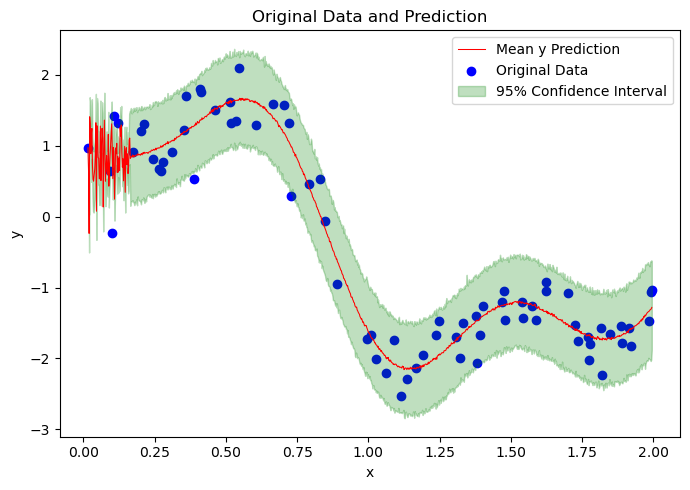

In [10]:
# apply function with specific arguments as required
plot_gp(pred1, d1)

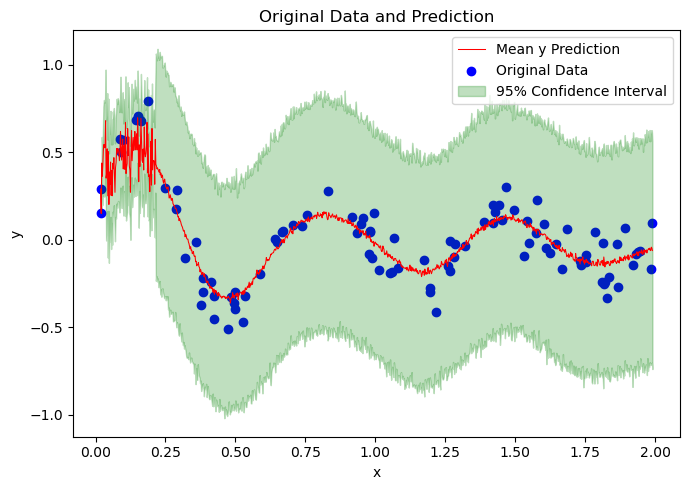

In [11]:
# apply function with specific arguments as required
plot_gp(pred2, d2)

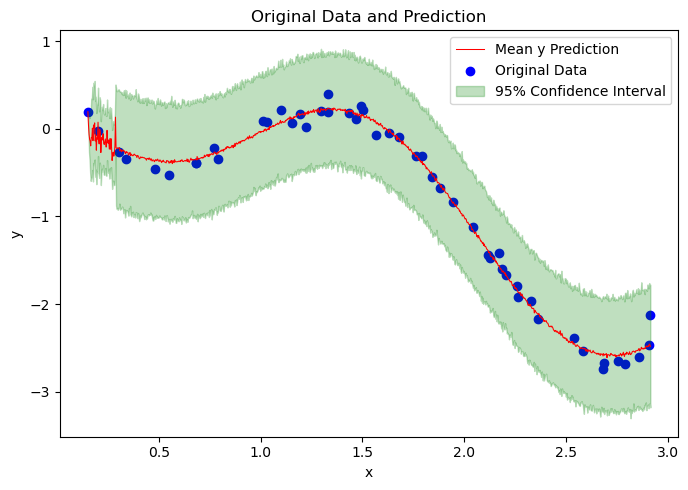

In [12]:
# apply function with specific arguments as required
plot_gp(pred3, d3)